# Onset Benchmark

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/onset-benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies
        !git clone https://github.com/inspektral/music2latent.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils
import test_signals


2025-06-21 14:08:53.275372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 14:08:53.453744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-21 14:08:53.490103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-21 14:08:53.502996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 14:08:53.705119: I tensorflow/core/platform/cpu_feature_guar

In [6]:
tests = test_signals.get_tests()
print(f"{len(tests)} tests found:")
for key in tests.keys():
    print(f"{key}")

13 tests found:
square_slow
square_fast
square_vibrato
saw_noise
sines_noise
filter_saw
triangle_clip
fm_amplitude
fm_frequency
delay_noise
delay_saw
reverb_noise
reverb_saw


In [7]:
SAMPLE_RATE = 44100
CURRENT_TEST = "square_slow"
SMALL = False

In [8]:
test = tests[CURRENT_TEST]
print(f"Running test: {test.__name__}")
test_name = test.__name__
audio, modulator = test()

plt.plot(audio, label='audio')
modulator = utils.norm(synth.stretch_array(modulator, len(audio)))
plt.plot(modulator, alpha=0.8, label='modulator')
plt.title(test.__name__)
plt.legend()

plt.show()

display(Audio(audio, rate=SAMPLE_RATE)) 

KeyError: 4

In [6]:
representations = utils.get_representations(audio)

Computing mfcc representation...
Computing cqt representation...
Computing spectrum representation...
Computing music2latent representation...
Computing dac representation...


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [7]:
print(representations.keys())

dict_keys(['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'])


In [8]:
import ipywidgets as widgets
from IPython.display import display

# Create checkboxes for all available representations
available_reps = list(representations.keys())
checkbox_widgets = {rep: widgets.Checkbox(
    value=rep in ['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'],
    description=rep,
    disabled=False
) for rep in available_reps}

# Create output widget to display results
output = widgets.Output()

def update_representations(change):
    with output:
        output.clear_output()
        to_keep = [rep for rep, checkbox in checkbox_widgets.items() if checkbox.value]
        global filtered_repr
        filtered_repr = {k: v for k, v in representations.items() if k in to_keep}
        print(f"Filtered representations: {list(filtered_repr.keys())}")

# Create a button to apply changes
apply_button = widgets.Button(description="Apply Selection")
apply_button.on_click(lambda b: update_representations(None))

# Layout the widgets
vbox_checkboxes = widgets.VBox([checkbox_widgets[rep] for rep in available_reps])
widget_box = widgets.VBox([
    widgets.Label("Select representations to keep:"), 
    vbox_checkboxes, 
    apply_button, 
    output
])

# Display the widget
display(widget_box)

# Initial filtering
to_keep = [rep for rep, checkbox in checkbox_widgets.items() if checkbox.value]
filtered_repr = {k: v for k, v in representations.items() if k in to_keep}

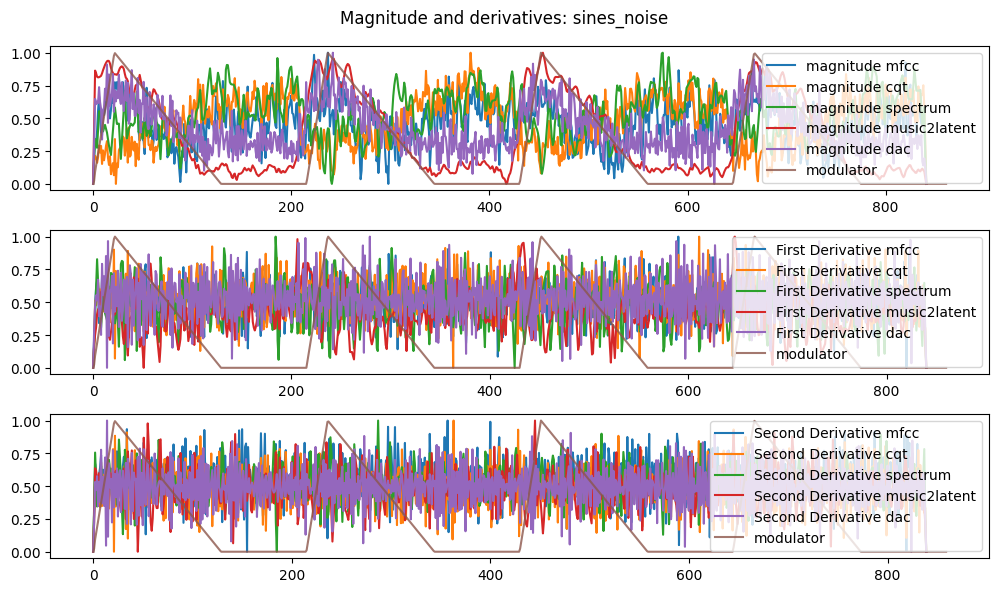

In [9]:
magnitude, d_magnitude, dd_magnitude = utils.calculate_metric(filtered_repr, np.linalg.norm, {"axis": 0})


utils.plot_with_derivatives(
    magnitude,
    d_magnitude,
    dd_magnitude,
    modulator,
    label="magnitude",
    title="Magnitude and derivatives: "+test_name,
    small=SMALL
)

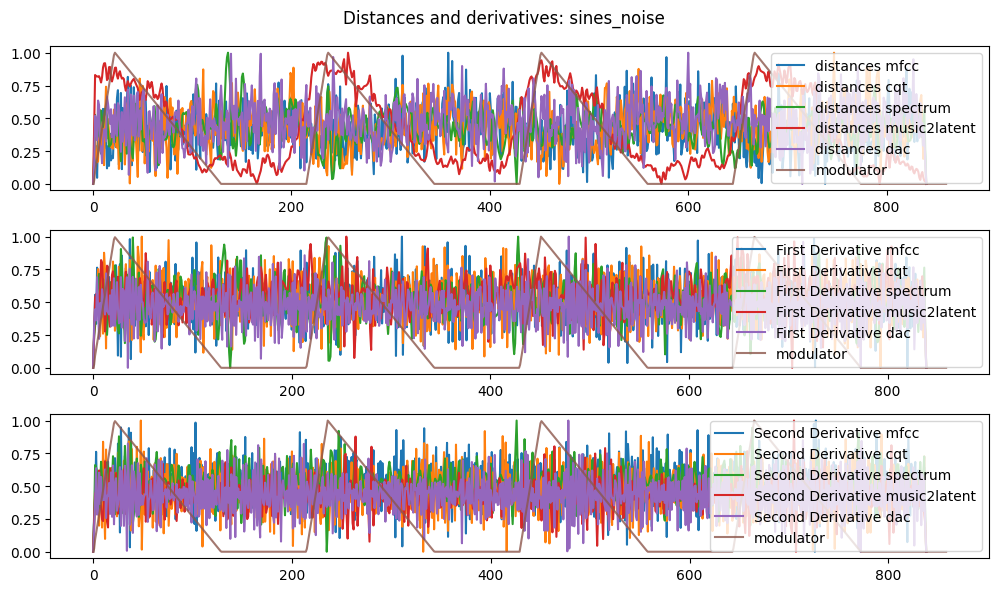

In [10]:
distances, d_distances, dd_distances = utils.calculate_metric(filtered_repr, utils.distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    modulator,
    label="distances",
    title="Distances and derivatives: "+test_name,
    small=SMALL
)


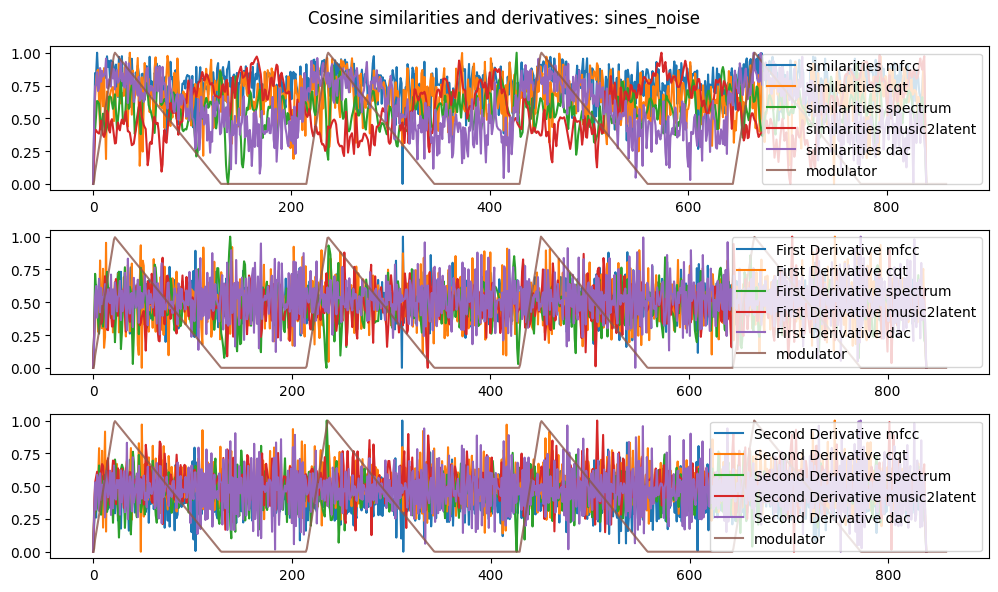

In [11]:
similarities, d_similarities, dd_similarities = utils.calculate_metric(filtered_repr, utils.cosine_similarity)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    modulator,
    label="similarities",
    title="Cosine similarities and derivatives: "+test_name,
    small=SMALL
)

In [12]:
correlation_magnitude = utils.get_correlations(magnitude, modulator)
correlation_distances = utils.get_correlations(distances, modulator)
correlation_similarities = utils.get_correlations(similarities, modulator)

print("Correlation with modulator (magnitude):")
for key in filtered_repr.keys():
    print(f"{key}: {correlation_magnitude[key]:.4f}")
print(f"best representation: {max(correlation_magnitude.keys(), key=lambda k: np.abs(correlation_magnitude[k]))}")

print("Correlation with modulator (distances):")
for key in filtered_repr.keys():
    print(f"{key}: {correlation_distances[key]:.4f}")
print(f"best representation: {max(correlation_distances.keys(), key=lambda k: np.abs(correlation_distances[k]))}")

print("Correlation with modulator (similarities):")
for key in filtered_repr.keys():
    print(f"{key}: {correlation_similarities[key]:.4f}")
print(f"best representation: {max(correlation_similarities.keys(), key=lambda k: np.abs(correlation_similarities[k]))}")


Correlation with modulator (magnitude):
mfcc: 0.1529
cqt: -0.8393
spectrum: -0.5603
music2latent: 0.9664
dac: 0.8568
best representation: music2latent
Correlation with modulator (distances):
mfcc: -0.3065
cqt: -0.3835
spectrum: -0.1868
music2latent: 0.9386
dac: -0.1370
best representation: music2latent
Correlation with modulator (similarities):
mfcc: 0.3024
cqt: 0.0973
spectrum: 0.0354
music2latent: -0.7254
dac: 0.8356
best representation: dac


In [13]:
import pandas as pd

LOAD_DATA = True

In [14]:
def correlations_dataframe(tests=tests):
    results = pd.DataFrame()

    for i, key in enumerate(tests.keys()):
        print(f"Running test: {key}, number {i+1}/{len(tests)}")
        audio, modulator = tests[key]()
        representations = utils.get_representations(audio)

        magnitude, _, _ = utils.calculate_metric(representations, np.linalg.norm, {"axis": 0})
        distances, _, _ = utils.calculate_metric(representations, utils.distances)
        similarities, _, _ = utils.calculate_metric(representations, utils.cosine_similarity)

        correlation_magnitude = utils.get_correlations(magnitude, modulator)
        correlation_distances = utils.get_correlations(distances, modulator)
        correlation_similarities = utils.get_correlations(similarities, modulator)

        row = {
        'test': key,
        **{"magnitude_" + k: v for k, v in correlation_magnitude.items()},
        **{"distances_" + k: v for k, v in correlation_distances.items()},
        **{"similarities_" + k: v for k, v in correlation_similarities.items()}
    }

        results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)
       

    return results

if LOAD_DATA:
    results = pd.read_csv('results.csv')
else:
    results = correlations_dataframe(tests)
    results.to_csv('results.csv', index=False)
    print("Results saved to results.csv")
    LOAD_DATA = True



,test,magnitude_mfcc,magnitude_cqt,magnitude_spectrum,magnitude_music2latent,magnitude_dac,distances_mfcc,distances_cqt,distances_spectrum,distances_music2latent,distances_dac,similarities_mfcc,similarities_cqt,similarities_spectrum,similarities_music2latent,similarities_dac
0,square_slow,0.863168,0.922163,0.955217,0.964625,0.839968,0.595327,0.527020,0.236940,0.936386,0.837657,0.474831,0.698102,0.367826,0.826757,0.309650
1,square_fast,0.695957,0.714455,0.600215,0.250383,0.859426,0.124003,0.352037,0.163505,0.233335,0.773739,0.271611,0.465636,0.165690,0.230605,0.630086
2,square_vibrato,0.219850,0.270950,0.115339,0.084753,0.595602,0.011675,0.053098,0.079361,0.497410,0.651012,0.081695,0.020988,0.088413,0.496670,0.668412
3,saw_noise,0.958451,0.817017,0.286933,0.706875,0.273439,0.145145,0.030754,0.110913,0.754739,0.387006,0.764371,0.303731,0.013111,0.666807,0.161207
4,sines_noise,0.777097,0.829771,0.577827,0.965459,0.733742,0.272895,0.565540,0.115855,0.945140,0.665260,0.364753,0.332598,0.053733,0.789400,0.008213
5,filter_saw,0.995261,0.152295,0.958194,0.587679,0.449053,0.121774,0.125942,0.074602,0.164629,0.592523,0.002883,0.238818,0.024992,0.028900,0.031456
6,triangle_clip,0.962493,0.790868,0.919034,0.740505,0.958045,0.300707,0.204065,0.127958,0.196194,0.960912,0.019977,0.055672,0.074717,0.679919,0.477431
7,fm_amplitude,0.876013,0.845504,0.795137,0.859402,0.081217,0.003129,0.519818,0.093104,0.628887,0.099215,0.023703,0.352487,0.045248,0.872056,0.152830
8,fm_frequency,0.412961,0.108063,0.275957,0.516499,0.113006,0.149792,0.134861,0.281791,0.010646,0.184083,0.049275,0.110568,0.255421,0.474710,0.274515
9,delay_noise,0.633152,0.621445,0.601235,0.513689,0.412178,0.192626,0.149835,0.200850,0.202213,0.453185,0.178811,0.328490,0.523289,0.184363,0.111876


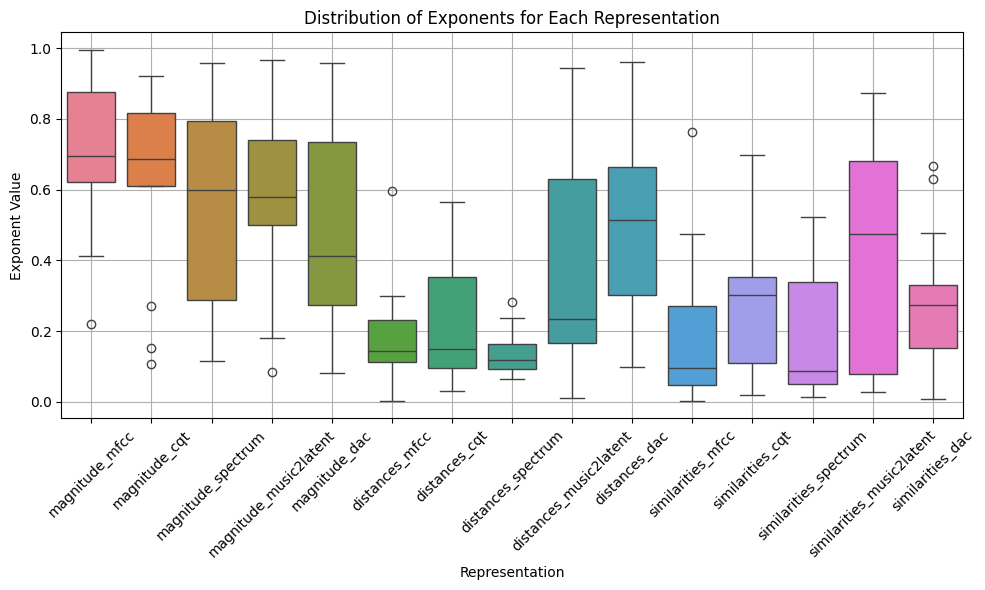

In [15]:
numeric_columns = results.select_dtypes(include=[np.number]).columns.tolist()
results[numeric_columns] = np.abs(results[numeric_columns])

display(results)
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=results)
plt.title('Distribution of Exponents for Each Representation')
plt.xlabel('Representation')
plt.ylabel('Exponent Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Optimizations

- Convexity compensation
- Smoothing
- NMF

In [16]:
audio, modulator = tests["saw_noise"]()
representations = utils.get_representations(audio)
magnitude, _, _ = utils.calculate_metric(representations, np.linalg.norm, {"axis": 0})

Computing mfcc representation...
Computing cqt representation...
Computing spectrum representation...
Computing music2latent representation...
Computing dac representation...


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [17]:
from scipy.optimize import minimize

def calculate_best_exponent(sig, modulator):
    sig = utils.stretch_array(utils.norm(sig), len(modulator))

    def loss(exponent):
        transformed = utils.norm(sig ** exponent[0])
        print(f"Exponent: {exponent[0]}")
        return 1-np.abs(utils.calc_correlation(modulator, transformed))

    result = minimize(loss, x0=[1.0], bounds=[(0.001, 10)])
    best_exponent = result.x[0]
    return best_exponent

best_exponent = calculate_best_exponent(magnitude["dac"], modulator)
print(best_exponent)


Exponent: 1.0
Exponent: 1.00000001
Exponent: 1.0120493837862496
Exponent: 1.0120493937862496
Exponent: 1.3542650705917043
Exponent: 1.3542650805917043
Exponent: 1.3788945506203976
Exponent: 1.3788945606203975
Exponent: 1.3807127637717629
Exponent: 1.3807127737717628
1.3807127637717629


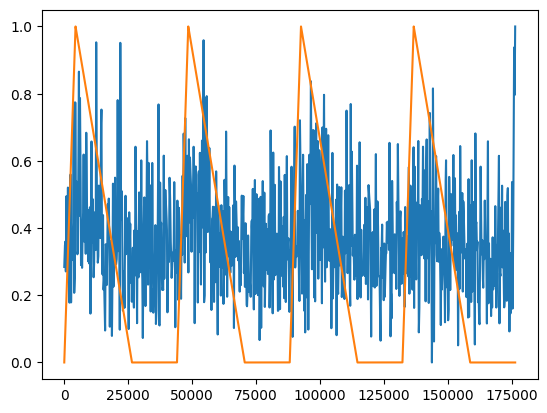

In [18]:
plt.plot(utils.norm(utils.stretch_array(magnitude["dac"]**best_exponent, len(modulator))), label='dac')
plt.plot(modulator, label='modulator')

In [19]:
from skopt import gp_minimize
from skopt.space import Integer

def calculate_best_smoothing(sig, modulator):
    sig = utils.stretch_array(utils.norm(sig), len(modulator))
    
    def objective(smoothing_factor):
        print(f"Smoothing factor: {smoothing_factor[0]}")
        smoothed = utils.smooth(sig, smoothing_factor[0])
        correlation = np.abs(np.corrcoef(smoothed, modulator)[0, 1])
        return -correlation  # Minimize negative = maximize positive
    
    result = gp_minimize(objective, 
                        dimensions=[Integer(1, 5000)],
                        n_calls=50,  # Only 50 evaluations!
                        random_state=42)
    
    return result.x[0]

Computing mfcc representation...
Computing cqt representation...
Computing spectrum representation...
Computing music2latent representation...
Computing dac representation...


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Exponent: 1.0
Exponent: 1.00000001
Exponent: 0.9521535395819823
Exponent: 0.9521535495819824
Exponent: 0.47746852116866917
Exponent: 0.47746853116866916
Exponent: 0.6149871047063611
Exponent: 0.6149871147063611
Exponent: 0.5906597958662302
Exponent: 0.5906598058662302
Exponent: 0.5888679150512833
Exponent: 0.5888679250512834
Best exponent for MFCC: 0.5888679150512833
Correlation before exponentiation: -0.8596
Smoothing factor: 3983
Smoothing factor: 918
Smoothing factor: 3899
Smoothing factor: 2985
Smoothing factor: 2230
Smoothing factor: 501
Smoothing factor: 2297
Smoothing factor: 1669
Smoothing factor: 715
Smoothing factor: 3255
Smoothing factor: 4999
Smoothing factor: 2262
Smoothing factor: 2298
Smoothing factor: 2
Smoothing factor: 2237
Smoothing factor: 1749
Smoothing factor: 2244
Smoothing factor: 1805
Smoothing factor: 3702
Smoothing factor: 2221
Smoothing factor: 2300
Smoothing factor: 2033
Smoothing factor: 3094
Smoothing factor: 2549
Smoothing factor: 2261
Smoothing factor: 

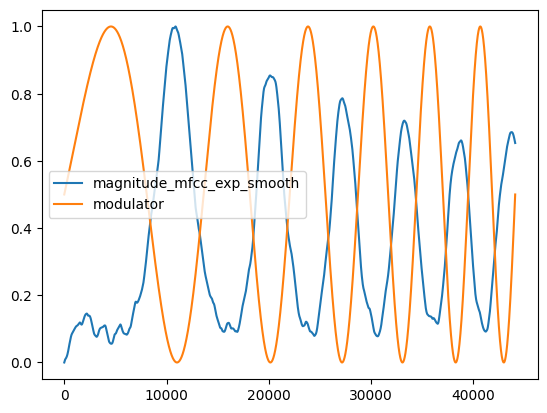

In [20]:
audio, modulator = tests["fm_amplitude"]()
repr_string = "music2latent"

modulator = utils.stretch_array(utils.norm(modulator), int(len(modulator)/10))
representations = utils.get_representations(audio)

magnitude, _, _ = utils.calculate_metric(representations, np.linalg.norm, {"axis": 0})
best_exponent_mfcc = calculate_best_exponent(magnitude[repr_string], modulator)
print(f"Best exponent for MFCC: {best_exponent_mfcc}")

correlation_before = utils.calc_correlation(modulator, magnitude[repr_string])
print(f"Correlation before exponentiation: {correlation_before:.4f}")
magnitude_mfcc_exp = utils.norm(magnitude[repr_string]** best_exponent_mfcc)
best_smoothing_mfcc = calculate_best_smoothing(magnitude_mfcc_exp, modulator)
print(f"Best smoothing for MFCC: {best_smoothing_mfcc}")
magnitude_mfcc_exp_smooth = utils.smooth(utils.stretch_array(magnitude_mfcc_exp, len(modulator)), best_smoothing_mfcc)

correlation_after = utils.calc_correlation(modulator, magnitude_mfcc_exp_smooth)
print(f"Correlation after exponentiation: {correlation_after:.4f}")

# plt.plot(utils.norm(utils.stretch_array(magnitude["mfcc"], len(modulator))), label='magnitude_mfcc')
# plt.plot(utils.norm(utils.stretch_array(magnitude_mfcc_exp, len(modulator))), label='magnitude_mfcc_exp')
plt.plot(utils.norm(magnitude_mfcc_exp_smooth), label='magnitude_mfcc_exp_smooth')
plt.plot(utils.norm(modulator), label='modulator')
plt.legend()
plt.show()


In [21]:
results_optimized = pd.DataFrame()

LOAD_DATA = True

if LOAD_DATA:
    results_optimized = pd.read_csv('results_optimized.csv')
else:
    for i, key in enumerate(tests.keys()):
        print(f"Running test: {key}, number {i+1}/{len(tests)}")
        audio, modulator = tests[key]()
        representations = utils.get_representations(audio)

        magnitude, _, _ = utils.calculate_metric(representations, np.linalg.norm, {"axis": 0})
        best_exponents_magnitude = {key : calculate_best_exponent(magnitude[key], modulator) for key in magnitude.keys()}
        magnitude = {key : utils.norm(magnitude[key]**best_exponents_magnitude[key]) for key in magnitude.keys()}
        
        distances, _, _ = utils.calculate_metric(representations, utils.distances)
        best_exponents_distances = {key : calculate_best_exponent(distances[key], modulator) for key in distances.keys()}
        distances = {key: utils.norm(distances[key]**best_exponents_distances[key]) for key in distances.keys()}

        similarities, _, _ = utils.calculate_metric(representations, utils.cosine_similarity)
        best_exponents_similarities = {key : calculate_best_exponent(similarities[key], modulator) for key in similarities.keys()}
        similarities = {key: utils.norm(similarities[key]**best_exponents_similarities[key]) for key in similarities.keys()}

        correlation_magnitude = utils.get_correlations(magnitude, modulator)
        correlation_distances = utils.get_correlations(distances, modulator)
        correlation_similarities = utils.get_correlations(similarities, modulator)

        print(f"Best magnitude exponents for {key}:")
        for k, v in best_exponents_magnitude.items():
            print(f"{k}: {v:.4f}")

        row = {
            'test': key,
            **{"magnitude_" + k: v for k, v in correlation_magnitude.items()},
            **{"magnitude_exponent_" + k : v for k, v in best_exponents_magnitude.items() },
            **{"distances_" + k: v for k, v in correlation_distances.items()},
            **{"distances_exponent_" + k : v for k, v in best_exponents_distances.items() },
            **{"similarities_" + k: v for k, v in correlation_similarities.items()},
            **{"similarities_exponent_" + k : v for k, v in best_exponents_similarities.items() }

        }

        results_optimized = pd.concat([results_optimized, pd.DataFrame([row])], ignore_index=True)
        # results.to_csv('results_optimized.csv', index=False)
        # print("Results saved to results_optimized.csv")
    results_optimized.to_csv('results_optimized.csv', index=False)
    print("Results saved to results_optimized.csv")


In [22]:
numeric_columns = results_optimized.select_dtypes(include=[np.number]).columns.tolist()
results_optimized[numeric_columns] = np.abs(results_optimized[numeric_columns])

In [23]:
display(results_optimized)

,test,magnitude_mfcc,magnitude_cqt,magnitude_spectrum,magnitude_music2latent,magnitude_dac,magnitude_exponent_mfcc,magnitude_exponent_cqt,magnitude_exponent_spectrum,magnitude_exponent_music2latent,...,similarities_mfcc,similarities_cqt,similarities_spectrum,similarities_music2latent,similarities_dac,similarities_exponent_mfcc,similarities_exponent_cqt,similarities_exponent_spectrum,similarities_exponent_music2latent,similarities_exponent_dac
0,square_slow,0.931727,0.930410,0.960229,0.964711,0.933206,0.182518,0.422560,0.463504,0.916851,...,0.474764,0.698261,0.367867,0.828418,NaN,5.594961,2.348757,0.445991,0.312551,0.210209
1,square_fast,0.737923,0.763221,0.614647,0.250629,0.913065,0.001000,0.001000,0.001000,0.757073,...,0.446573,0.467492,0.173285,0.237754,NaN,10.000000,5.441312,10.000000,5.449045,0.750913
2,square_vibrato,0.259811,0.270865,0.117493,0.092167,0.596071,0.001000,1.146672,0.498739,0.131034,...,0.108765,0.021290,0.088422,0.499488,NaN,10.000000,0.001000,1.456801,1.823776,0.048546
3,saw_noise,0.954543,0.810256,0.371277,0.491164,0.234377,1.231011,0.644769,0.123030,3.679110,...,0.905269,0.239018,0.103425,0.754533,0.175475,7.803012,0.949770,2.070631,0.853313,2.049526
4,sines_noise,0.477698,0.920153,0.521899,0.960580,0.799476,3.196549,0.575794,0.381302,1.030883,...,0.557451,0.210324,0.067752,0.906768,0.527938,6.546373,5.517293,1.261330,0.997439,1.602201
5,filter_saw,0.995632,0.164153,0.959788,0.588163,0.449165,0.770923,10.000000,2.421704,1.461529,...,0.002929,0.239197,0.025291,0.031591,NaN,10.000000,0.339121,10.000000,4.008568,3.166124
6,triangle_clip,0.962687,0.843114,0.941968,0.741090,0.958324,0.945321,3.756292,3.980345,1.335524,...,0.056624,0.067309,0.076622,0.685528,NaN,10.000000,10.000000,10.000000,2.902059,2.934598
7,fm_amplitude,0.890288,0.857379,0.874037,0.862727,0.085407,0.361916,2.037947,4.946362,0.590663,...,0.043216,0.377583,0.046471,0.872052,0.157489,10.000000,10.000000,10.000000,1.152459,0.114653
8,fm_frequency,0.413227,0.208621,0.290116,0.520714,0.118323,1.271903,7.165526,4.495490,1.824108,...,0.052714,0.110981,0.256078,0.494087,NaN,5.868193,4.336267,5.655216,3.178549,2.071467
9,delay_noise,0.658962,0.613733,0.613235,0.495139,0.443469,0.621233,0.950393,1.060017,1.233692,...,0.384904,0.407662,0.610452,0.260708,NaN,10.000000,10.000000,2.038164,0.001000,6.907044


,magnitude_mfcc,magnitude_cqt,magnitude_spectrum,magnitude_music2latent,magnitude_dac,distances_mfcc,distances_cqt,distances_spectrum,distances_music2latent,distances_dac,similarities_mfcc,similarities_cqt,similarities_spectrum,similarities_music2latent,similarities_dac
0,0.931727,0.930410,0.960229,0.964711,0.933206,0.638254,0.529103,0.305834,0.959229,0.929570,0.474764,0.698261,0.367867,0.828418,NaN
1,0.737923,0.763221,0.614647,0.250629,0.913065,0.535818,0.354123,0.387156,0.238028,0.826238,0.446573,0.467492,0.173285,0.237754,NaN
2,0.259811,0.270865,0.117493,0.092167,0.596071,0.075871,0.087457,0.080448,0.497393,0.854512,0.108765,0.021290,0.088422,0.499488,NaN
3,0.954543,0.810256,0.371277,0.491164,0.234377,0.241311,0.051644,0.044293,0.798317,0.372492,0.905269,0.239018,0.103425,0.754533,0.175475
4,0.477698,0.920153,0.521899,0.960580,0.799476,0.472601,0.608331,0.227499,0.961132,0.589587,0.557451,0.210324,0.067752,0.906768,0.527938
5,0.995632,0.164153,0.959788,0.588163,0.449165,0.274989,0.403116,0.092395,0.184741,0.592649,0.002929,0.239197,0.025291,0.031591,NaN
6,0.962687,0.843114,0.941968,0.741090,0.958324,0.427234,0.391878,0.150537,0.224177,0.961770,0.056624,0.067309,0.076622,0.685528,NaN
7,0.890288,0.857379,0.874037,0.862727,0.085407,0.007614,0.561836,0.267622,0.630445,0.101312,0.043216,0.377583,0.046471,0.872052,0.157489
8,0.413227,0.208621,0.290116,0.520714,0.118323,0.160130,0.181001,0.293790,NaN,0.184121,0.052714,0.110981,0.256078,0.494087,NaN
9,0.658962,0.613733,0.613235,0.495139,0.443469,0.190921,0.171806,0.217472,0.378481,0.440350,0.384904,0.407662,0.610452,0.260708,NaN


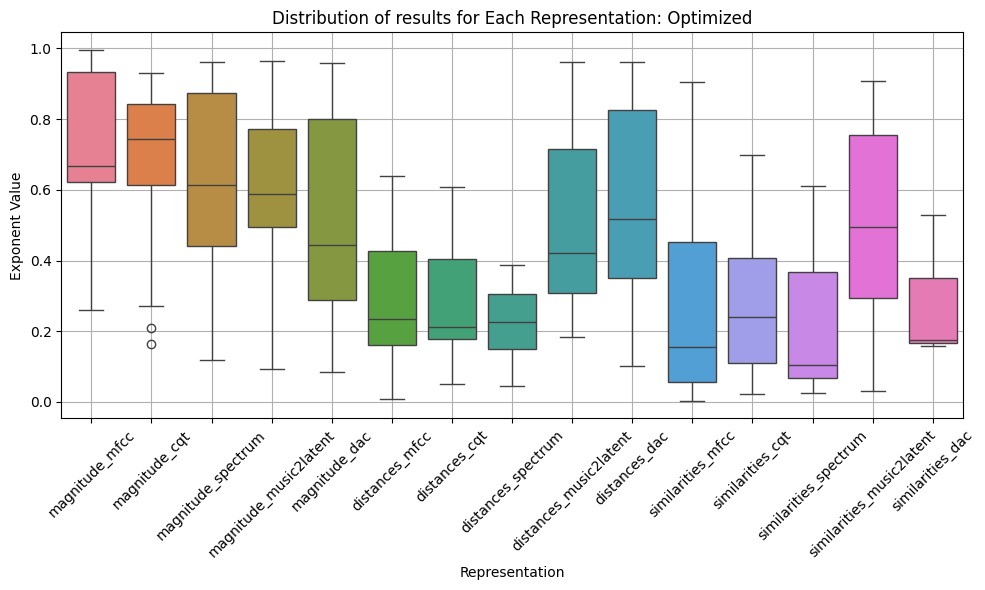

In [24]:
non_exponents = results_optimized.loc[:, ~results_optimized.columns.str.contains('_exponent|test')]
display(non_exponents)

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=non_exponents)
plt.title('Distribution of results for Each Representation: Optimized')
plt.xlabel('Representation')
plt.ylabel('Exponent Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

,magnitude_exponent_mfcc,magnitude_exponent_cqt,magnitude_exponent_spectrum,magnitude_exponent_music2latent,magnitude_exponent_dac,distances_exponent_mfcc,distances_exponent_cqt,distances_exponent_spectrum,distances_exponent_music2latent,distances_exponent_dac,similarities_exponent_mfcc,similarities_exponent_cqt,similarities_exponent_spectrum,similarities_exponent_music2latent,similarities_exponent_dac
0,0.182518,0.422560,0.463504,0.916851,0.019219,0.448703,1.135913,3.604465,2.108870,0.001000,5.594961,2.348757,0.445991,0.312551,0.210209
1,0.001000,0.001000,0.001000,0.757073,2.306465,0.001000,0.640735,0.001000,0.445007,3.005012,10.000000,5.441312,10.000000,5.449045,0.750913
2,0.001000,1.146672,0.498739,0.131034,0.845920,2.887365,3.240940,0.391346,1.121007,6.260985,10.000000,0.001000,1.456801,1.823776,0.048546
3,1.231011,0.644769,0.123030,3.679110,1.054711,0.238895,0.001000,0.001000,1.549651,0.797399,7.803012,0.949770,2.070631,0.853313,2.049526
4,3.196549,0.575794,0.381302,1.030883,0.684021,0.519603,0.434794,0.526008,1.446360,1.318638,6.546373,5.517293,1.261330,0.997439,1.602201
5,0.770923,10.000000,2.421704,1.461529,1.076018,0.193699,10.000000,0.260822,4.534265,0.856132,10.000000,0.339121,10.000000,4.008568,3.166124
6,0.945321,3.756292,3.980345,1.335524,0.915569,0.306921,0.001000,0.524031,0.055793,0.815975,10.000000,10.000000,10.000000,2.902059,2.934598
7,0.361916,2.037947,4.946362,0.590663,5.121250,1.639918,0.163926,0.001000,0.508181,2.290400,10.000000,10.000000,10.000000,1.152459,0.114653
8,1.271903,7.165526,4.495490,1.824108,2.156042,1.323591,2.969204,0.469140,8.589066,1.025938,5.868193,4.336267,5.655216,3.178549,2.071467
9,0.621233,0.950393,1.060017,1.233692,0.001000,1.213534,1.508712,2.427824,4.281879,0.719226,10.000000,10.000000,2.038164,0.001000,6.907044


,magnitude_mfcc,magnitude_cqt,magnitude_spectrum,magnitude_music2latent,magnitude_dac,distances_mfcc,distances_cqt,distances_spectrum,distances_music2latent,distances_dac,similarities_mfcc,similarities_cqt,similarities_spectrum,similarities_music2latent,similarities_dac
0,0.931727,0.930410,0.960229,0.964711,0.933206,0.638254,0.529103,0.305834,0.959229,0.929570,0.474764,0.698261,0.367867,0.828418,NaN
1,0.737923,0.763221,0.614647,0.250629,0.913065,0.535818,0.354123,0.387156,0.238028,0.826238,0.446573,0.467492,0.173285,0.237754,NaN
2,0.259811,0.270865,0.117493,0.092167,0.596071,0.075871,0.087457,0.080448,0.497393,0.854512,0.108765,0.021290,0.088422,0.499488,NaN
3,0.954543,0.810256,0.371277,0.491164,0.234377,0.241311,0.051644,0.044293,0.798317,0.372492,0.905269,0.239018,0.103425,0.754533,0.175475
4,0.477698,0.920153,0.521899,0.960580,0.799476,0.472601,0.608331,0.227499,0.961132,0.589587,0.557451,0.210324,0.067752,0.906768,0.527938
5,0.995632,0.164153,0.959788,0.588163,0.449165,0.274989,0.403116,0.092395,0.184741,0.592649,0.002929,0.239197,0.025291,0.031591,NaN
6,0.962687,0.843114,0.941968,0.741090,0.958324,0.427234,0.391878,0.150537,0.224177,0.961770,0.056624,0.067309,0.076622,0.685528,NaN
7,0.890288,0.857379,0.874037,0.862727,0.085407,0.007614,0.561836,0.267622,0.630445,0.101312,0.043216,0.377583,0.046471,0.872052,0.157489
8,0.413227,0.208621,0.290116,0.520714,0.118323,0.160130,0.181001,0.293790,NaN,0.184121,0.052714,0.110981,0.256078,0.494087,NaN
9,0.658962,0.613733,0.613235,0.495139,0.443469,0.190921,0.171806,0.217472,0.378481,0.440350,0.384904,0.407662,0.610452,0.260708,NaN


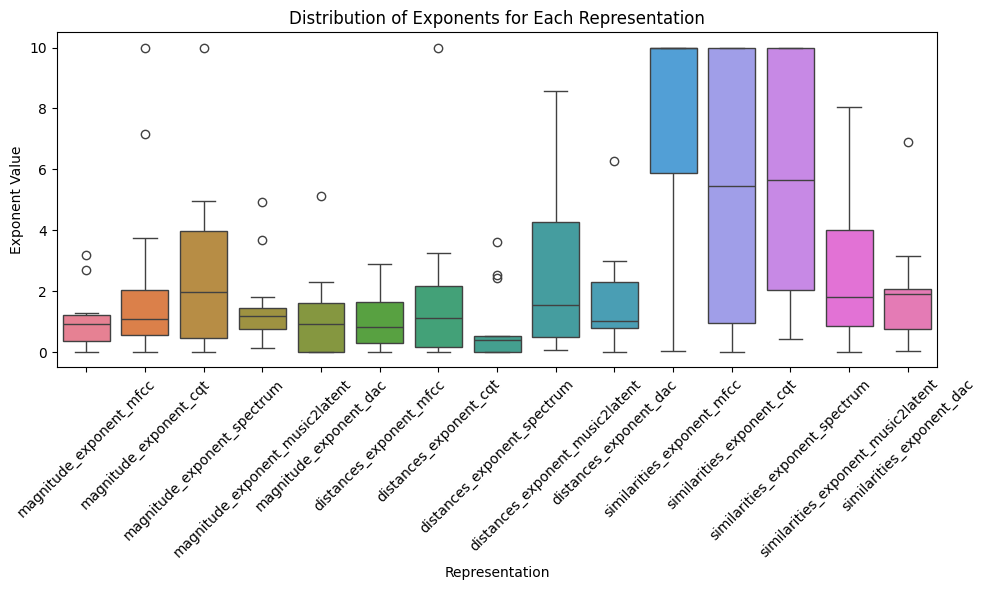

In [25]:
exponents = results_optimized.filter(like='_exponent')
display(exponents)

# Get non-exponent columns (excluding the 'test' column)
non_exponents = results_optimized.loc[:, ~results_optimized.columns.str.contains('_exponent|test')]
display(non_exponents)


import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=exponents)
plt.title('Distribution of Exponents for Each Representation')
plt.xlabel('Representation')
plt.ylabel('Exponent Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Computing mfcc representation...
Computing cqt representation...
Computing spectrum representation...
Computing music2latent representation...
Computing dac representation...


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


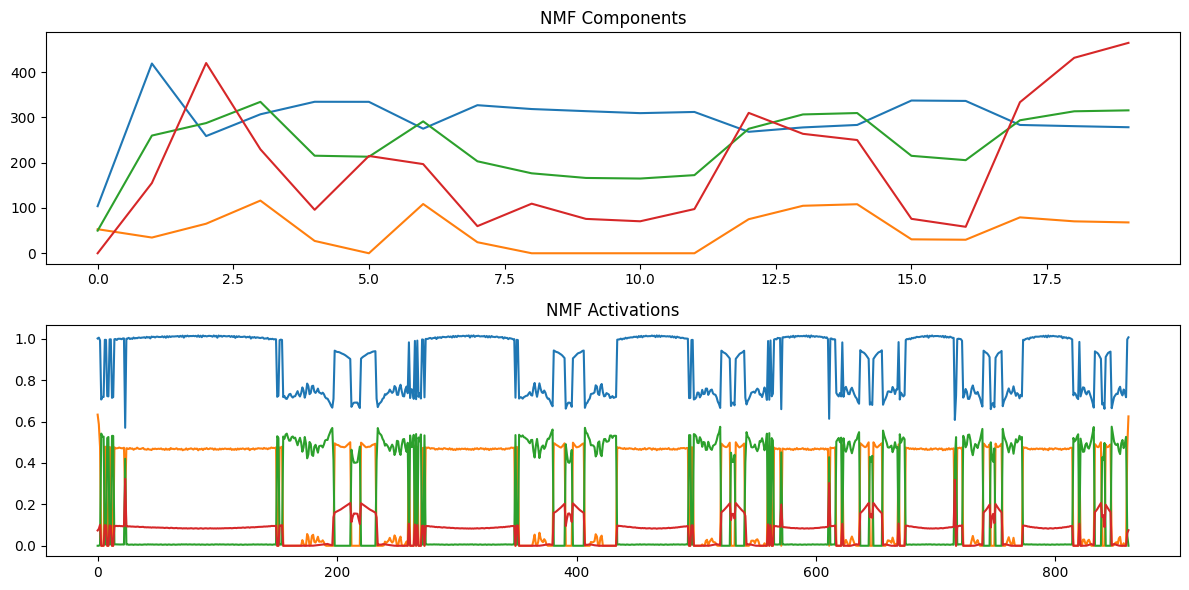

In [33]:
audio, modulator = tests["fm_amplitude"]()
repr_string = "mfcc"

modulator = utils.stretch_array(utils.norm(modulator), int(len(modulator)/10))
representations = utils.get_representations(audio)

# NMF
import librosa

minimum = np.abs(np.min(representations[repr_string]))

components, activations = librosa.decompose.decompose(
    representations[repr_string]+minimum,
    n_components=4,
    sort=True,
    random_state=42
)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(components)
plt.title('NMF Components')
plt.subplot(2, 1, 2)
plt.plot(activations.T)
plt.title('NMF Activations')
plt.tight_layout()
plt.show()

In [34]:
print(components.shape)
print(activations.shape)

(20, 4)
(4, 862)
